### This jupyter notebook employs a CNN to learn the mapping between input current configuration between output magnetic field 

In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [3]:
from ReadData import ReadCurrentAndField_CNN
import glob
import os 

# TODO zhoujing edit this Data loading 
# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
current,data = ReadCurrentAndField_CNN (foldername,filepattern)

fileList = glob.glob(foldername+filepattern)
position = data[:,0:3,0:20,0:20,0:20]
Bfield = data[:,3:,0:20,0:20,0:20]

# print(fileList)
print(data.shape)
print('current shape', current.shape)
print('Bfield shape', Bfield.shape)



torch.Size([1000, 6, 21, 21, 21])
current shape torch.Size([1000, 12])
Bfield shape torch.Size([1000, 3, 20, 20, 20])


In [4]:
Bfield_mean=torch.mean(Bfield,0)
print(Bfield_mean)

tensor([[[[ 6.2018e-04,  6.0811e-04,  5.9341e-04,  ...,  5.5032e-04,
            5.5467e-04,  5.6250e-04],
          [ 5.7249e-04,  5.6254e-04,  5.5354e-04,  ...,  5.4932e-04,
            5.5721e-04,  5.6586e-04],
          [ 5.2511e-04,  5.2076e-04,  5.1648e-04,  ...,  5.4965e-04,
            5.5902e-04,  5.6927e-04],
          ...,
          [ 4.4690e-05,  7.4700e-05,  1.0453e-04,  ...,  5.3723e-04,
            5.6762e-04,  5.9805e-04],
          [ 1.1213e-05,  4.5553e-05,  7.7126e-05,  ...,  5.3798e-04,
            5.7006e-04,  6.0042e-04],
          [-2.1167e-05,  1.3652e-05,  4.9866e-05,  ...,  5.3903e-04,
            5.7169e-04,  6.0527e-04]],

         [[ 6.7961e-04,  6.6085e-04,  6.4353e-04,  ...,  5.6251e-04,
            5.6657e-04,  5.7176e-04],
          [ 6.2750e-04,  6.1430e-04,  6.0212e-04,  ...,  5.6172e-04,
            5.6764e-04,  5.7401e-04],
          [ 5.8098e-04,  5.7111e-04,  5.6268e-04,  ...,  5.6100e-04,
            5.6860e-04,  5.7661e-04],
          ...,
     

In [5]:
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset
num_input = 12
output_shape = (3,20,20,20)
SB_args = (64,64,4) # (Cin, Cout, num_block)
BB_args = (2,2) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
print(Generative_network)

Generative_net(
  (proj): Linear(in_features=12, out_features=8000, bias=True)
  (conv3d): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (total_net): Sequential(
    (0): Linear(in_features=12, out_features=8000, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 5, 5, 5))
    (2): BigBlock(
      (block): Sequential(
        (0): ResidualEMNSBlock_3d(
          (block): Sequential(
            (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (2): LeakyReLU(negative_slope=0.01)
          )
          (shortcut): Identity()
        )
        (1): ResidualEMNSBlock_3d(
          (block): Sequential(
            (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (2): LeakyReLU(ne

In [7]:
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset
from Training_loop import train_part_GM,get_mean_of_dataloader


batch_size = 128
# construct dataset
dataset = eMNS_Dataset(
    train_x=current,
    train_y=Bfield
)


###############################################
# Config the neural network
###############################################
num_input = 12
output_shape = (3,20,20,20)
SB_args = (64,64,4) # (Cin, Cout, num_block)
BB_args = (2,2) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
epochs = 50
learning_rate_decay = .1
learning_rates = [1e-3]
schedule = []
weight_decays = [0]

train_percents = np.arange(1.0,1.1,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
loss_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))

################################################
# Train the neural network
################################################
index=0
for train_percent in train_percents:
    epoch_stop = 0
    print('train_percent',train_percent)
    for learning_rate in learning_rates:
        for weight_decay in weight_decays:

            # split the dataset to train, validation, test
            train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

            #Using Dataloader for batch train
            train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
            valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)

            get_mean_of_dataloader(valid_loader,model=Generative_network,device=device)
            print("----------------------------")
            
            print("----------------------------")
            # test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

            Generative_network.apply(weight_init)
            optimizer = torch.optim.Adam([{'params':Generative_network.parameters()}], lr=learning_rate, weight_decay= weight_decay)
            RMSE_history, RMSE_val_history, loss_history, iter_history, loss_val_history,epoch_stop,Rsquare= train_part_GM(model=Generative_network, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, epochs=epochs, learning_rate_decay=learning_rate_decay, schedule=schedule, weight_decay=weight_decay, verbose=False, device=device)
    
    #save RMSE and loss after early stopping
    RMSE_history_end[index] = RMSE_history[epoch_stop]
    RMSE_val_history_end[index]= RMSE_val_history[epoch_stop]
    loss_history_end[index] = loss_history[epoch_stop]
    iter_history_end[index] = iter_history[epoch_stop]
    loss_val_history_end[index] = loss_val_history[epoch_stop]
    index=index+1
    print('training stop at epoch:',epoch_stop)
    print('training stop at epoch:',Rsquare)
    


train_percent 1.0
1
----------------------------
----------------------------
Epoch 0, Iteration 8, loss = 0.3521
1
Got RMSE 0.0032493893522769213
8
8
8
8
8
8
8
8


d:\QubotGit\QubotGitFile\Qubot_Elastica\Modeling eMNS\Training_loop.py:438: UserWarning: Using a target size (torch.Size([100, 3, 20, 20, 20])) that is different to the input size (torch.Size([3, 20, 20, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  R_temp += F.mse_loss(Bfield_mean, y, reduce='sum')
d:\QubotGit\QubotGitFile\Qubot_Elastica\Modeling eMNS\Training_loop.py:438: UserWarning: Using a target size (torch.Size([128, 3, 20, 20, 20])) that is different to the input size (torch.Size([3, 20, 20, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  R_temp += F.mse_loss(Bfield_mean, y, reduce='sum')
d:\QubotGit\QubotGitFile\Qubot_Elastica\Modeling eMNS\Training_loop.py:438: UserWarning: Using a target size (torch.Size([4, 3, 20, 20, 20])) that is different to the input size (torch.Size([3, 20, 20, 20])). This will likely lead to incorrect results due to broadca

Got RMSE 0.003256490221247077

Validation loss decreased (inf --> 0.000011).  Saving model ...
Epoch 1, Iteration 16, loss = 0.2107
1
Got RMSE 0.0017065209103748202
8
8
8
8
8
8
8
8
Got RMSE 0.0017305511282756925

EarlyStopping counter: 1 out of 10
Epoch 2, Iteration 24, loss = 0.1357
1
Got RMSE 0.0011401325464248657
8
8
8
8
8
8
8
8
Got RMSE 0.001150732976384461

EarlyStopping counter: 2 out of 10
Epoch 3, Iteration 32, loss = 0.0986
1
Got RMSE 0.0008187073399312794
8
8
8
8
8
8
8
8
Got RMSE 0.0008387962589040399

EarlyStopping counter: 3 out of 10
Epoch 4, Iteration 40, loss = 0.0746
1
Got RMSE 0.0006265276460908353
8
8
8
8
8
8
8
8
Got RMSE 0.0006368368049152195

EarlyStopping counter: 4 out of 10
Epoch 5, Iteration 48, loss = 0.0639
1
Got RMSE 0.0005255514406599104
8
8
8
8
8
8
8
8
Got RMSE 0.0005288752727210522

EarlyStopping counter: 5 out of 10
Epoch 6, Iteration 56, loss = 0.0510
1
Got RMSE 0.00048029221943579614
8
8
8
8
8
8
8
8
Got RMSE 0.0004922320367768407

EarlyStopping counter:

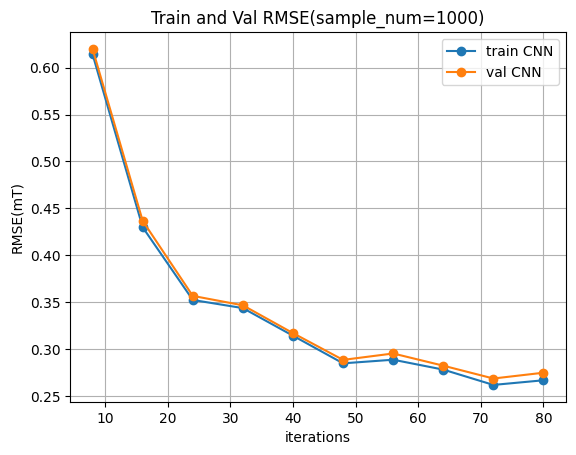

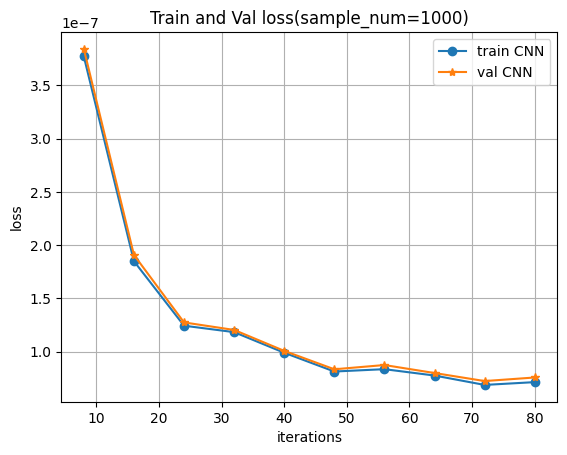

In [22]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')
plt.title('Train and Val RMSE(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],RMSE_history[0:epoch_stop]*1000,'-o')
plt.plot(iter_history[0:epoch_stop],RMSE_val_history[0:epoch_stop]*1000,'-o')
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('RMSE(mT)')
plt.grid()
plt.show()


plt.title('Train and Val loss(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],loss_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],loss_val_history[0:epoch_stop],'-*')
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.grid()
plt.show()